In [1]:
import sys
sys.path.append('..')
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from utils import commons
from models.mlp import MLPModel
from datasets.sequence_dataset import SingleLabelSequenceDataset
import matplotlib.pyplot as plt
import numpy as np
import os, json
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.manifold import TSNE

device = 'cuda:0'

def generate_embeddings(model, dataloader, label_list):
    embeddings, labels = [], []
    with torch.no_grad():
        for data, label in tqdm(dataloader):
            output, feature = model(data.to(device))
            embeddings.append(commons.toCPU(feature))
            label = label.tolist()
            label = [label_list[i] for i in label]
            labels.extend(label)
    embeddings = torch.cat(embeddings, dim=0)
    assert len(embeddings) == len(labels)
    return embeddings, labels

def get_ec2occurance(data_file, label_file):
    data = torch.load(data_file)
    with open(label_file, 'r') as f:
        label_list = json.load(f)
    ec2occurance = {label: 0 for label in label_list}
    for k, v in data.items():
        for label in v['ec']:
            ec2occurance[label] += 1
    
    return ec2occurance, label_list

def get_label2mean(embeddings, labels):
    label2embeddings = {label: [] for label in labels}
    assert len(embeddings) == len(labels), f'{len(embeddings)} != {len(labels)}'
    n = len(embeddings)
    for i in range(n):
        label2embeddings[labels[i]].append(embeddings[i])
    label2mean = {label: torch.stack(embeddings).mean(dim=0) for label, embeddings in label2embeddings.items()}
    return label2mean

def get_pairwise_angle(means):
    g_mean = means.mean(dim=0)
    centered_mean = means - g_mean
    means_ = F.normalize(centered_mean, p=2, dim=1)
    cosine = torch.matmul(means_, means_.t())
    angles = torch.acos(cosine)
    for i in range(angles.size(0)):
        angles[i, i] = 0
    
    return angles

# model_dir = '../logs/train_mlp_single_label_CE_2024_02_13__09_48_52'
model_dir = '../logs/train_mlp_single_label_NC_2024_02_13__11_23_21_0.01_1.0'
test_data_file = '../data/ec/sprot_10_1022_esm2_t33_ec_above_10_single_label_test.pt'
train_data_file = '../data/ec/sprot_10_1022_esm2_t33_ec_above_10_single_label_train.pt'
label_file = '../data/ec/swissprot_ec_list_above_10.json'

# dataset
trainset = SingleLabelSequenceDataset(train_data_file, label_file)
testset = SingleLabelSequenceDataset(test_data_file, label_file)
train_loader = DataLoader(trainset, batch_size=512, shuffle=False)
test_loader = DataLoader(testset, batch_size=512, shuffle=False)
with open(label_file, 'r') as f:
    label_list = json.load(f)
label2idx = {label: i for i, label in enumerate(label_list)}
ec2occurance, label_list = get_ec2occurance(train_data_file, label_file)

config = commons.load_config(os.path.join(model_dir, 'config.yml'))
model = globals()[config.model.model_type](config.model)
ckpt = torch.load(os.path.join(model_dir, 'checkpoints/best_checkpoints.pt'))
model.load_state_dict(ckpt)
model.eval()
model.to(device)

train_embeddings, train_labels = generate_embeddings(model, train_loader, label_list)
test_embeddings, test_labels = generate_embeddings(model, test_loader, label_list)
train_label2mean = get_label2mean(train_embeddings, train_labels)
test_label2mean = get_label2mean(test_embeddings, test_labels)
train_pairwise_angle = get_pairwise_angle(torch.stack(list(train_label2mean.values())))
test_pairwise_angle = get_pairwise_angle(torch.stack(list(test_label2mean.values())))
train_label_set, test_label_set = list(train_label2mean.keys()), list(test_label2mean.keys())
assert len(train_pairwise_angle) == len(train_label_set) and len(test_pairwise_angle) == len(test_label_set)

[2024-02-15 17:23:33,834::SequenceDataset::INFO] Loaded 167108 sequences with ec labels
[2024-02-15 17:23:34,520::SequenceDataset::INFO] Loaded 20889 sequences with ec labels
[2024-02-15 17:23:34,520::SequenceDataset::INFO] Loaded 20889 sequences with ec labels


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

In [2]:
print(train_pairwise_angle.mean(), train_pairwise_angle.min(), train_pairwise_angle.max(), train_pairwise_angle.std())
print(test_pairwise_angle.mean(), test_pairwise_angle.min(), test_pairwise_angle.max(), test_pairwise_angle.std())

tensor(1.5697) tensor(0.) tensor(1.9050) tensor(0.1285)
tensor(1.5694) tensor(0.) tensor(1.8625) tensor(0.1346)


torch.Size([50, 50])


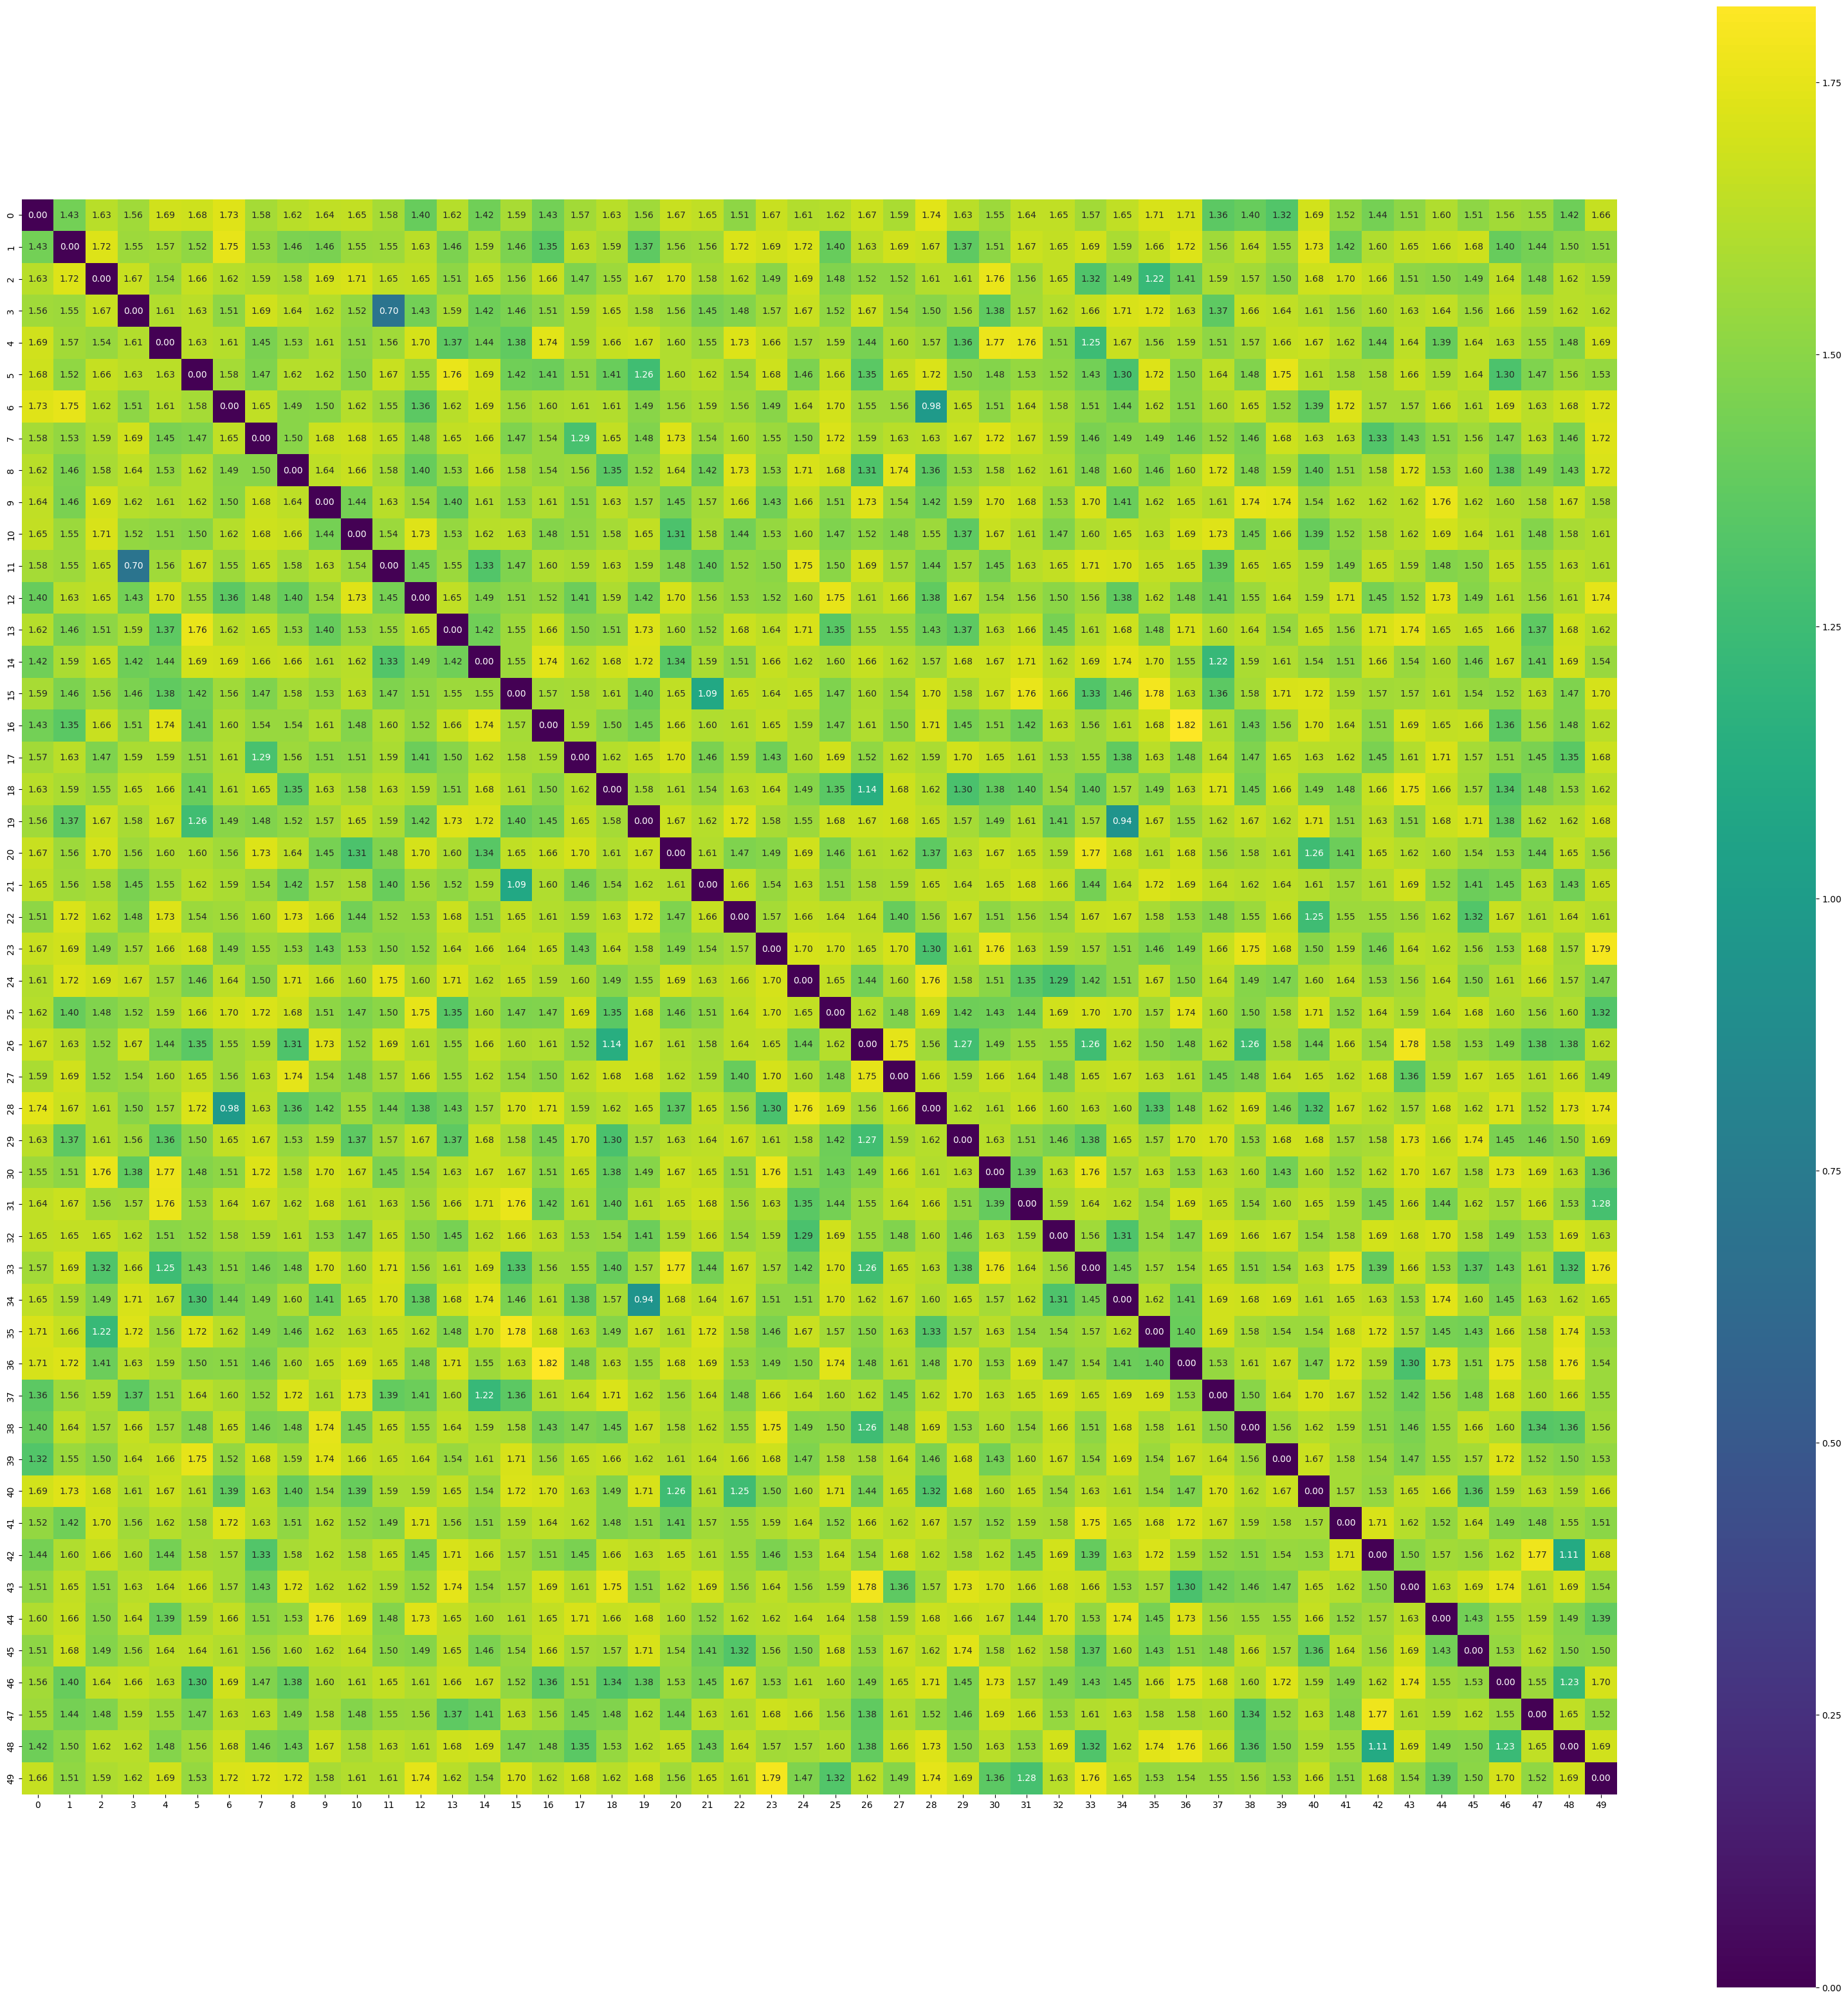

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

random.seed(42)
random_indices = random.sample(range(len(test_pairwise_angle)), 50)
subsampled_test_pairwise_angle = test_pairwise_angle[random_indices][:, random_indices]
print(subsampled_test_pairwise_angle.shape)
plt.figure(figsize=(40, 40))  # Adjust the figure size as needed
sns.heatmap(subsampled_test_pairwise_angle, annot=True, fmt=".2f", cmap='viridis', square=True, cbar=True)
plt.savefig(os.path.join(model_dir, 'pairwise_angle_test.png'))
plt.show()

In [4]:
cosine = -torch.tensor(1) / torch.tensor(1700)
torch.acos(cosine)

tensor(1.5714)